### 모델 테스트용 코드

- 모델 테스트 및 성능 평가

In [9]:
### Colab 사용시 주석 제거

# !rm -rf SKN19_2ND_5TEAM
# !git clone https://github.com/SKNetworks-AI19-250818/SKN19_2ND_5TEAM.git
# %cd SKN19_2ND_5TEAM

# import sys
# sys.path.append('/content/SKN19_2ND_5TEAM')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import modules.DataAnalysis as DataAnalysis
import modules.ModelAnalysis as ModelAnalysis
import modules.DataModify as DataModify
from modules.DataSelect import DataPreprocessing

import modules.Models as Models

In [ ]:
input_file_path = ['./data/2022Data_part1.csv', './data/2022Data_part2.csv']


# 랜덤 시드 고정 : 결과 비교용
Models.set_seed(42)

dp = DataPreprocessing()

# device 설정 (cuda 사용 가능 시 cuda 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset 로드
dataset = DataModify.CancerDataset(
    target_column='target_label',              # target column
    time_column='Survival months_bin_3m',      # Survival months
    file_paths=input_file_path,
    transform=dp.run                           # 기존에 정제가 완료된 데이터를 사용할 경우 None
)

Using device: cuda


d:\SKN_19\SKN19_2ND_5TEAM\modules\DataModify.py:446: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [4]:
def compute_survival_metrics(pmf: torch.Tensor):
    """
    DeepHit 모델 출력(PMF)로부터 주요 생존 지표 계산
    
    Args:
        pmf (torch.Tensor): 사건별 시간대 확률 분포 (B, E, T)
            - B: batch_size
            - E: num_events
            - T: time_bins

    Returns:
        dict: {
            'survival': (B, T) 생존확률,
            'risk_score': (B,) 사건발생 위험도,
            'expected_time': (B,) 기대 생존시간
        }
    """
    # ----- CIF (누적 사건 확률) -----
    cif = torch.cumsum(pmf, dim=2)  # (B, E, T)

    # ----- 1️⃣ 생존 확률 -----
    survival = 1 - torch.sum(cif, dim=1)  # (B, T)

    # ----- 2️⃣ 위험도 (전체 사건 발생 확률 합) -----
    risk_score = pmf.sum(dim=(1, 2))  # (B,)

    # ----- 3️⃣ 기대 생존 시간 -----
    time_index = torch.arange(1, pmf.shape[2] + 1, device=pmf.device).float()  # [1, 2, ..., T]
    expected_time = (survival * time_index).sum(dim=1)  # (B,)

    return {
        'survival': survival,
        'risk_score': risk_score,
        'expected_time': expected_time
    }

In [13]:
input_params_path = './data/parameters/deephit_model_without_feature_concat.pth'

input_dim = dataset.data.shape[1]   # input dimension : data의 feature의 개수
hidden_size = (128, 64)             # 1번째, 2번째 hidden layer의 size
time_bins = 91                     # 3개월 단위로 time을 split하여 각 구간으로 삼음 -> 최대 270개월 + 그 후
num_events = 4                      # 사건의 개수

# 모델 정의 (학습할 때 사용한 모델 클래스)
model = Models.DeepHitSurvWithSEBlock(input_dim, 
                    hidden_size, 
                    time_bins, 
                    num_events)  # 사건 수 맞게 설정
model.load_state_dict(torch.load(input_params_path, map_location=device))
model.to(device)
model.eval()  # 평가 모드

from torch.utils.data import DataLoader, Subset

test_subset = Subset(dataset, indices=list(range(5, 10)))
test_loader = DataLoader(test_subset, batch_size=5, shuffle=False)

with torch.no_grad():  # 평가 시에는 gradient 계산 필요 없음
    for x, times, events in test_loader: 
        x, times, events = x.to(device), times.to(device), events.to(device)

        # 모델 예측
        _, pmf, cif = model(x)

        # 마지막 시간축 제거 (더미 제거)
        pmf = pmf[:, :, :-1]
        cif = cif[:, :, :-1]

        # 생존 메트릭 계산
        metrics = ModelAnalysis.compute_survival_metrics(pmf)

        print("🔹 생존확률 (Survival):", metrics['survival'].shape)
        print(metrics['survival'][0])
        print("🔹 위험도 (Risk Score):", metrics['risk_score'])
        print("🔹 기대 생존시간 (Expected Time):", metrics['expected_time'])


🔹 생존확률 (Survival): torch.Size([5, 90])
tensor([ 0.9958,  0.9922,  0.9883,  0.9828,  0.9532,  0.9030,  0.8386,  0.7579,
         0.6851,  0.6356,  0.5855,  0.5483,  0.4994,  0.4586,  0.4334,  0.4084,
         0.3828,  0.3674,  0.3482,  0.3234,  0.3096,  0.2996,  0.2918,  0.2882,
         0.2481,  0.2407,  0.2314,  0.2267,  0.2175,  0.2078,  0.2013,  0.1855,
         0.1725,  0.1582,  0.1421,  0.1292,  0.1118,  0.0981,  0.0766,  0.0604,
         0.0442,  0.0308,  0.0201,  0.0080, -0.0212, -0.0468, -0.0609, -0.0852,
        -0.1112, -0.1304, -0.1545, -0.1834, -0.2123, -0.2400, -0.2713, -0.3046,
        -0.3362, -0.3566, -0.3907, -0.4091, -0.4318, -0.4511, -0.4811, -0.5114,
        -0.5450, -0.5699, -0.5945, -0.6289, -0.6530, -0.6870, -0.7210, -0.7506,
        -0.7775, -0.7936, -0.8073, -0.8282, -0.8611, -0.9023, -0.9460, -0.9914,
        -1.0487, -1.1206, -1.1883, -1.2474, -1.3149, -1.3890, -1.4630, -1.5850,
        -1.8728, -2.2570], device='cuda:0')
🔹 위험도 (Risk Score): tensor([3.2570, 3

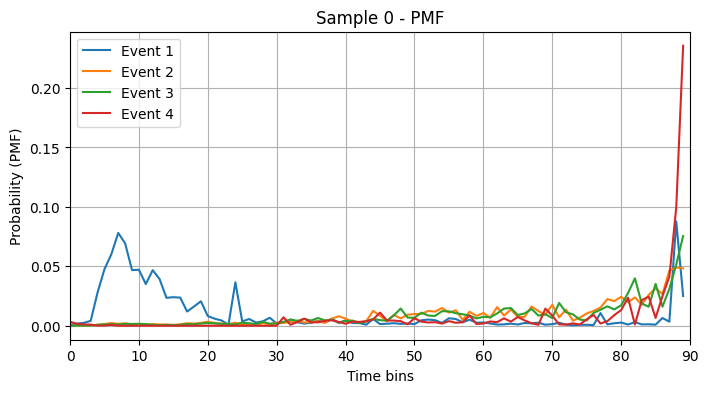

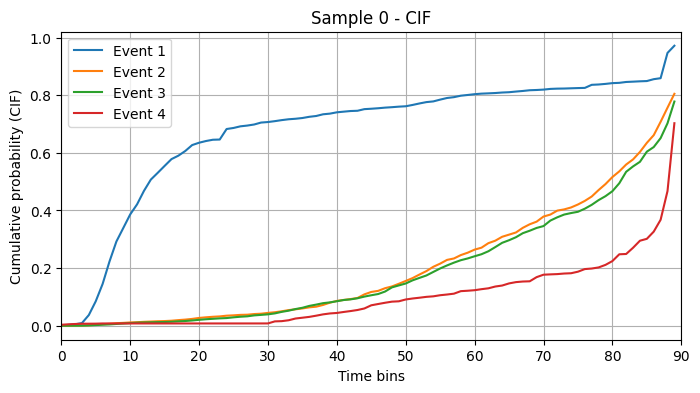

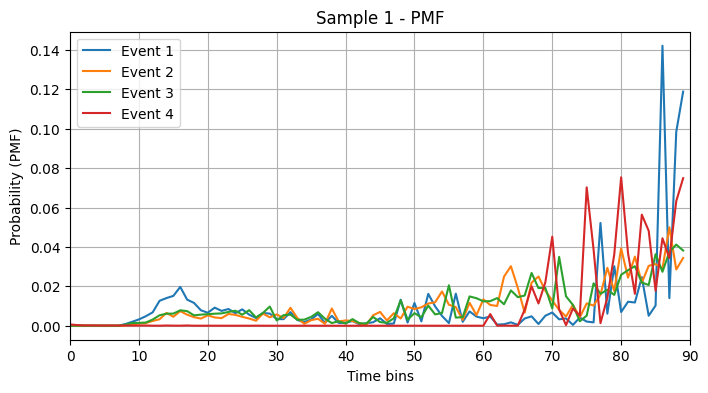

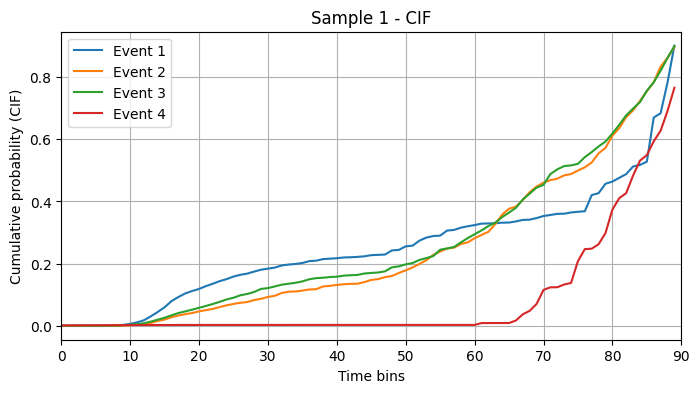

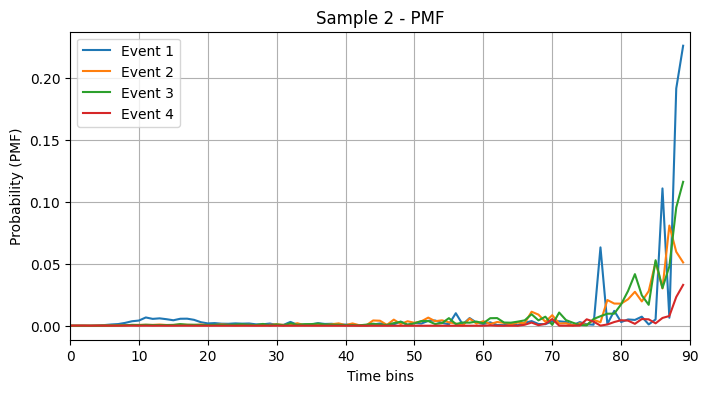

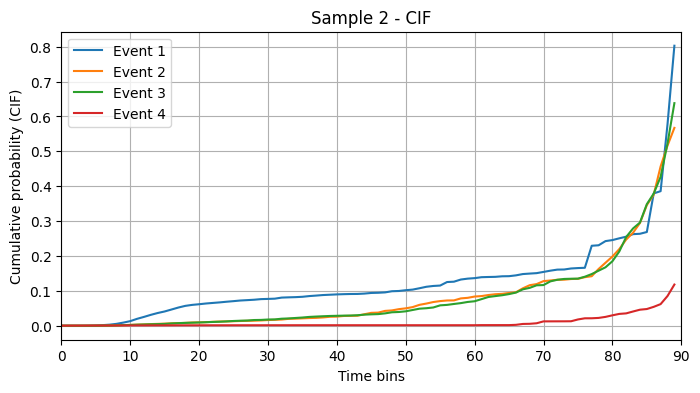

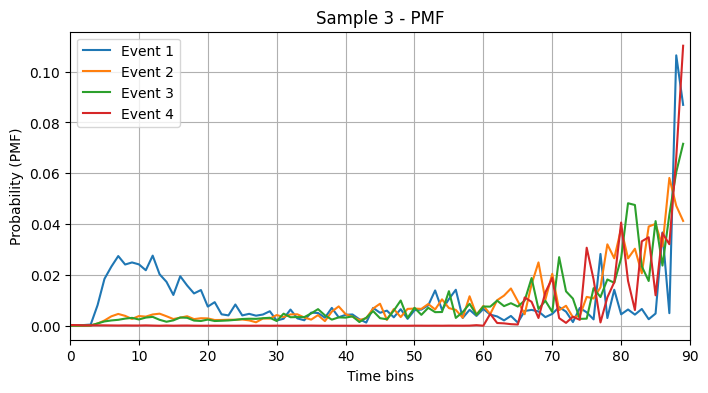

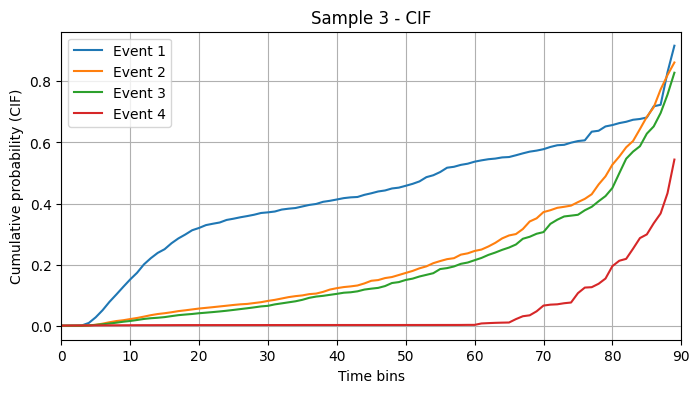

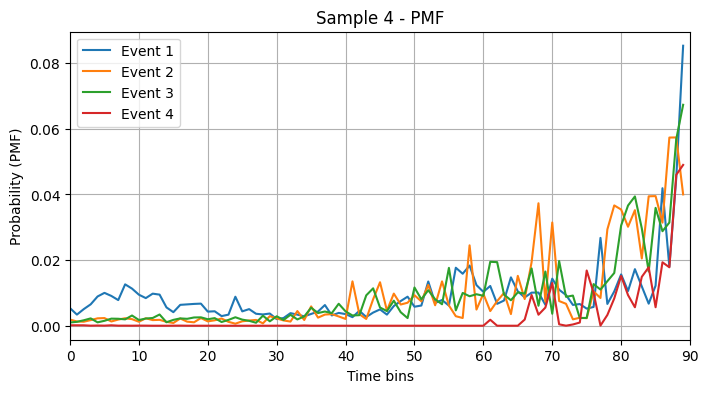

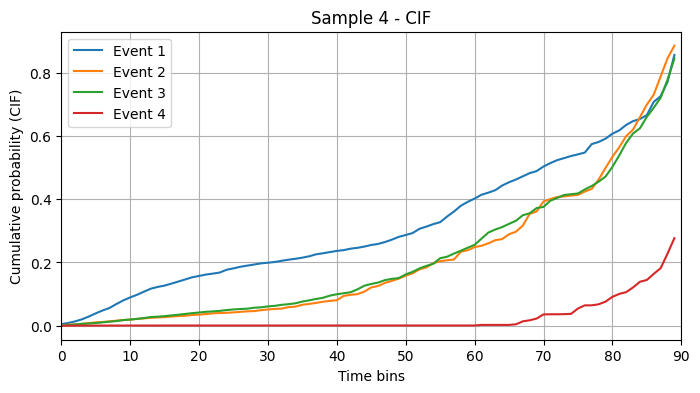

In [15]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for x, times, events in test_loader: 
        x, times, events = x.to(device), times.to(device), events.to(device)

        _, pmf, cif = model(x)  # pmf, cif: (batch_size, num_events, time_bins)

        # 마지막 시간 bin 제거
        pmf = pmf[:, :, :-1]
        cif = cif[:, :, :-1]
        batch_size, num_events, time_bins = cif.shape
        time_points = list(range(time_bins))  # 시간축, 마지막 더미 제거됨

        for i in range(batch_size):
            # ===== PMF =====
            plt.figure(figsize=(8,4))
            for k in range(num_events):
                plt.plot(time_points, pmf[i, k].cpu().numpy().flatten(), label=f'Event {k+1}')
            plt.xlabel('Time bins')
            plt.ylabel('Probability (PMF)')
            plt.title(f'Sample {i} - PMF')
            plt.legend()
            plt.grid(True)
            plt.xlim(0, 90)
            plt.show()

            # ===== CIF =====
            plt.figure(figsize=(8,4))
            for k in range(num_events):
                plt.plot(time_points, cif[i, k].cpu().numpy().flatten(), label=f'Event {k+1}')
            plt.xlabel('Time bins')
            plt.ylabel('Cumulative probability (CIF)')
            plt.title(f'Sample {i} - CIF')
            plt.legend()
            plt.grid(True)
            plt.xlim(0, 90)
            plt.show()
